# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import time
import ast

from gensim.utils import simple_preprocess

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn import manifold, decomposition

from sklearn import cluster, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec

from transformers import DistilBertTokenizer, DistilBertModel
import torch

import tensorflow as tf
import tensorflow_hub as hub


In [5]:
df = pd.read_csv("final_dataset.csv")

# Data preparation

In [6]:
df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x)[0])

# Label encoding
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["tags"])

In [7]:
df.head()

,Unnamed: 0,text,tags,label
0,8,protractor break loopi need help loop beak c...,javascript,6
1,25,electron proxy url create small server out...,javascript,6
2,41,angular materializecss modal dialog open...,javascript,6
3,46,throw new typeerror app use require middl...,javascript,6
4,72,display waiter resolve datum angular pr...,javascript,6


In [8]:
df.tags.value_counts()

python        4182
java          3626
ios           3389
c#            3344
php           2387
android       2288
javascript    1918
html           333
jquery         274
css            248
Name: tags, dtype: int64

## For TF-IDF, Word2Vec, USE

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

y_train, y_test = df_train["tags"], df_test["tags"]

## For BERT

As computation is too long, we reduce the size of the dataset from 20,000 to 1,000

In [10]:
df_BERT = df.sample(frac=1).reset_index(drop=True).iloc[:1000]

df_train_BERT, df_test_BERT = train_test_split(df_BERT, test_size=0.2, random_state=42)

y_train_BERT, y_test_BERT = df_train_BERT["tags"], df_test_BERT["tags"]

# Utils

In [11]:
def train_lda_model(model_name, X_train, X_test, y_train=y_train, y_test=y_test):
    # experiment with MLflow
    mlflow.set_experiment("OC_P5_Supervised_Classification")

    with mlflow.start_run():

        lda_model = LinearDiscriminantAnalysis()
        lda_model.fit(X_train, y_train)

        y_pred = lda_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        mlflow.log_param("tfidf_max_features", 3000)
        mlflow.log_param("ngram_range", "(1, 2)")
        mlflow.log_param("min_df", 5)
        mlflow.log_param("train_size", len(X_train))
        mlflow.log_param("test_size", len(X_test))
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        mlflow.sklearn.log_model(lda_model, model_name)

        print(f"Accuracy : {accuracy:.2f}")
        print(f"Precision : {precision:.2f}, Recall : {recall:.2f}, F1 Score : {f1:.2f}")
        print("Model saved in MLflow.")

    return lda_model

In [12]:
# t-SNE computation, clustering and ARI score
def ARI_fct(features, df_pred=df_test) :

    time1 = time.time()
    
    tsne = manifold.TSNE(
        n_components=2,
        perplexity=30,
        n_iter=2000,
        init='random',
        learning_rate=200,
        random_state=42
    )
    
    X_tsne = tsne.fit_transform(features)
    
    
    cls = cluster.KMeans(
        n_clusters=len(df_pred.label.unique()),
        n_init=100,
        random_state=42
    )
    cls.fit(X_tsne)

    ARI = np.round( metrics.adjusted_rand_score(df_pred.label, cls.labels_) , 4)
    
    time2 = np.round(time.time() - time1,0)
    
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# t-SNE visualization clusters/true catégories
def TSNE_visu_fct(X_tsne, ARI, _labels, df_pred=df_test) :
    
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=_labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(_labels), loc="best", title="Clusters")
    plt.title('Clusters after embedding')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=df_pred.label, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(df_pred.tags.unique()), loc="best", title="Categories")
    plt.title('Real categories')
    
    plt.show()
    print("ARI : ", ARI)


def report(Y_pred, df_pred=df_test, df=df):

    main_tags = list(df.tags.unique())

    report = classification_report(df_pred["tags"], Y_pred, labels=main_tags)
    matrix = confusion_matrix(df_pred["tags"], Y_pred, labels=main_tags)

    print(report)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=main_tags, yticklabels=main_tags)
    plt.show()

# TF_IDF

## Modelization

In [13]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=3000, min_df=10, max_df=0.95)

X_train_tfidf = vectorizer.fit_transform(df_train["text"]).toarray()
X_test_tfidf = vectorizer.transform(df_test["text"]).toarray()

lda_tfidf = train_lda_model("LDA TF-IDF", X_train_tfidf, X_test_tfidf)

2025/03/22 17:55:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy : 0.86
Precision : 0.87, Recall : 0.86, F1 Score : 0.87
Model saved in MLflow.


## Embedding visualization

In [14]:
ARI_tfidf, X_tsne_tfidf, labels_tfidf = ARI_fct(X_test_tfidf)

/home/omar-oc/anaconda3/envs/env_OC_P5_ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1423 time :  21.0


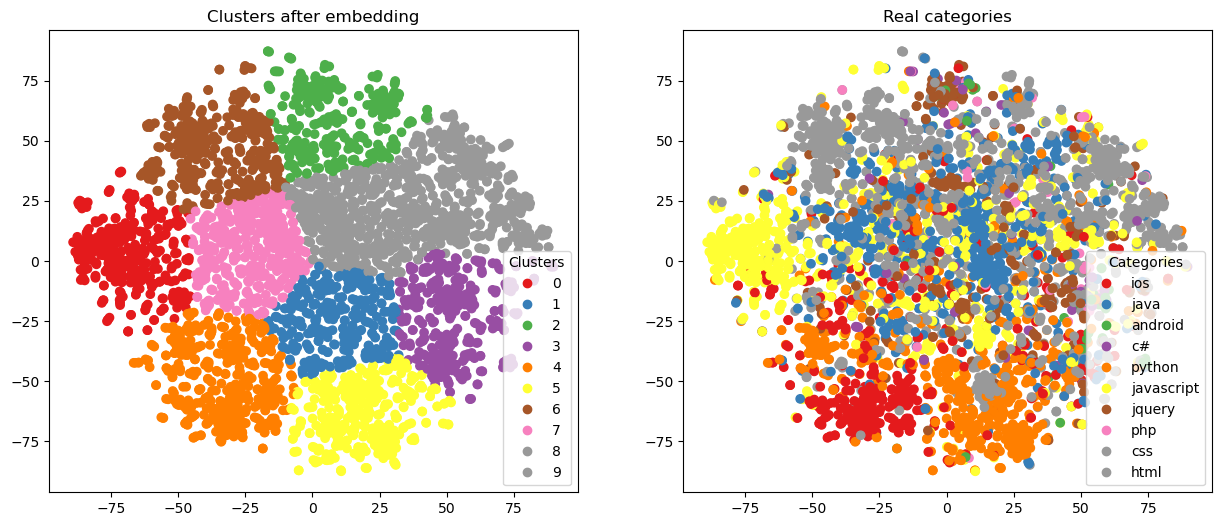

ARI :  0.1423


In [15]:
TSNE_visu_fct(X_tsne_tfidf, ARI_tfidf, labels_tfidf)

## Confusion matrix

              precision    recall  f1-score   support

  javascript       0.73      0.78      0.75       339
        java       0.88      0.87      0.88       762
        html       0.38      0.58      0.46        66
      python       0.93      0.92      0.93       871
      jquery       0.58      0.60      0.59        47
     android       0.91      0.80      0.85       471
         php       0.88      0.86      0.87       477
          c#       0.84      0.88      0.86       675
         ios       0.94      0.91      0.92       637
         css       0.63      0.74      0.68        53

    accuracy                           0.86      4398
   macro avg       0.77      0.79      0.78      4398
weighted avg       0.87      0.86      0.87      4398



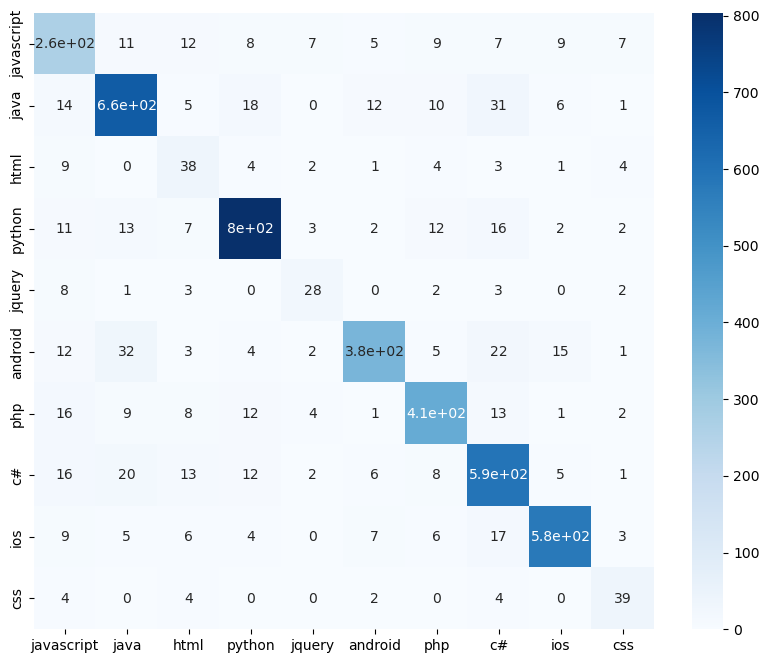

In [16]:
Y_pred_tfidf = lda_tfidf.predict(X_test_tfidf)
report(Y_pred_tfidf)

# Word2Vec

## Modelization

In [ ]:
# Tokenization
def tokenize_text(text):
    return word_tokenize(text.lower())


# Word2Vec embedding
def get_average_word2vec(tokens, model, vector_size=100):
    
    vectors = [model.wv[word] for word in tokens if word in model.wv] # mean only for the words in the vocabulary
    
    if len(vectors) == 0:  # if no word is found
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)


In [ ]:

df_train["tokens"] = df_train["text"].apply(tokenize_text)
df_test["tokens"] = df_test["text"].apply(tokenize_text)

# Build Word2Vec embedding on the corpus
word2vec_model = Word2Vec(sentences=df_train["text"].apply(tokenize_text), vector_size=100, window=5, min_count=1, workers=4)

# Get the embedding
X_train_w2v = np.array([get_average_word2vec(tokens, word2vec_model) for tokens in df_train["tokens"]])
X_test_w2v = np.array([get_average_word2vec(tokens, word2vec_model) for tokens in df_test["tokens"]])


lda_w2v = train_lda_model("LDA Word2Vec", X_train_w2v, X_test_w2v)


2025/03/22 16:07:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy : 0.80
Precision : 0.81, Recall : 0.80, F1 Score : 0.80
Model saved in MLflow.


## Embedding visualization

In [ ]:
ARI_w2v, X_tsne_w2v, labels_w2v = ARI_fct(X_test_w2v)

/home/omar-oc/anaconda3/envs/env_OC_P5_ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.171 time :  34.0


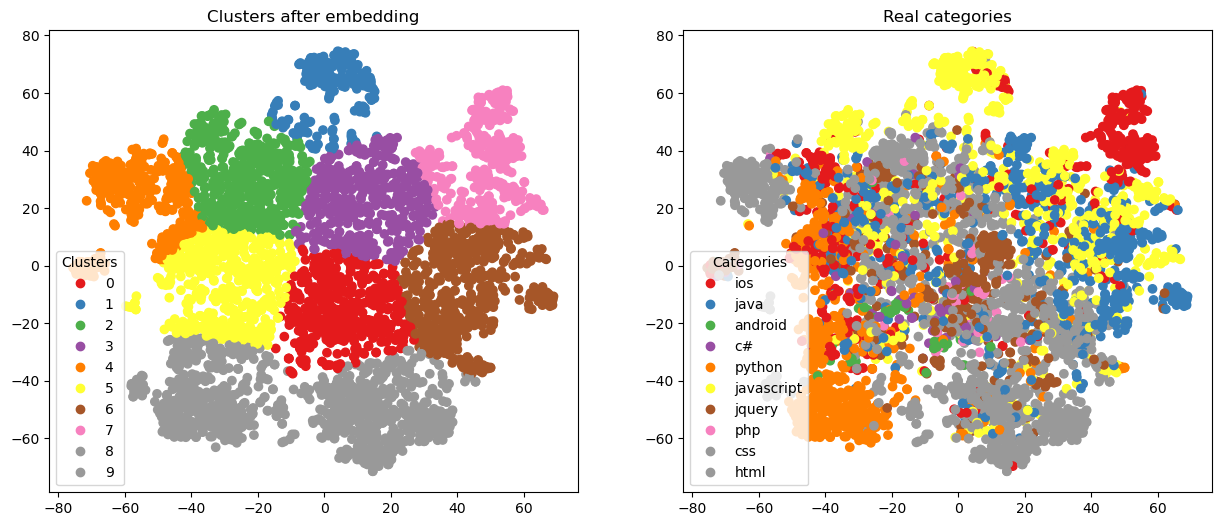

ARI :  0.171


In [ ]:
TSNE_visu_fct(X_tsne_w2v, ARI_w2v, labels_w2v)

## Confusion matrix

              precision    recall  f1-score   support

  javascript       0.72      0.74      0.73       339
        java       0.79      0.81      0.80       762
        html       0.35      0.52      0.41        66
      python       0.90      0.88      0.89       871
      jquery       0.36      0.38      0.37        47
     android       0.93      0.67      0.78       471
         php       0.75      0.77      0.76       477
          c#       0.72      0.81      0.77       675
         ios       0.92      0.88      0.90       637
         css       0.48      0.72      0.58        53

    accuracy                           0.80      4398
   macro avg       0.69      0.72      0.70      4398
weighted avg       0.81      0.80      0.80      4398



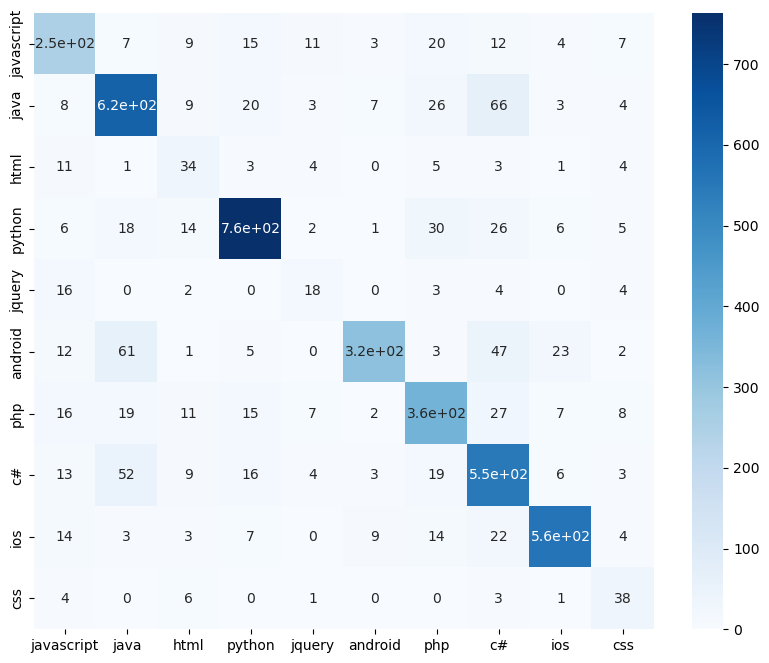

In [ ]:
Y_pred_w2v = lda_w2v.predict(X_test_w2v)
report(Y_pred_w2v)

# BERT

(dataset reduced due to the computation time of the BERT embedding)

## Modelisation

In [ ]:
# Tokenization and BERT embeddings extraction
def get_bert_embeddings(text, tokenizer, model):
    # Tokenisation
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract vector from first token
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()  # On prend le premier token [CLS]

In [ ]:
# Load tokenizer and pre-trained BERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Get BERT embeddings
X_train_BERT = np.array([get_bert_embeddings(text, tokenizer, model) for text in df_train_BERT["text"]])
X_test_BERT = np.array([get_bert_embeddings(text, tokenizer, model) for text in df_test_BERT["text"]])

lda_bert = train_lda_model("LDA BERT", X_train_BERT, X_test_BERT, y_train_BERT, y_test_BERT)


/home/omar-oc/anaconda3/envs/env_OC_P5_ter/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2025/03/22 16:16:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy : 0.18
Precision : 0.23, Recall : 0.18, F1 Score : 0.20
Model saved in MLflow.


<Experiment: artifact_location='file:///home/omar-oc/git/OC_machine_learning/P5/mlruns/759183157701873886', creation_time=1738573085538, experiment_id='759183157701873886', last_update_time=1738573085538, lifecycle_stage='active', name='OC_P5_Supervised_Classification', tags={}>

## Embedding visualization

In [ ]:
ARI_BERT, X_tsne_BERT, labels_BERT = ARI_fct(X_test_BERT, df_test_BERT)

/home/omar-oc/anaconda3/envs/env_OC_P5_ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0363 time :  1.0


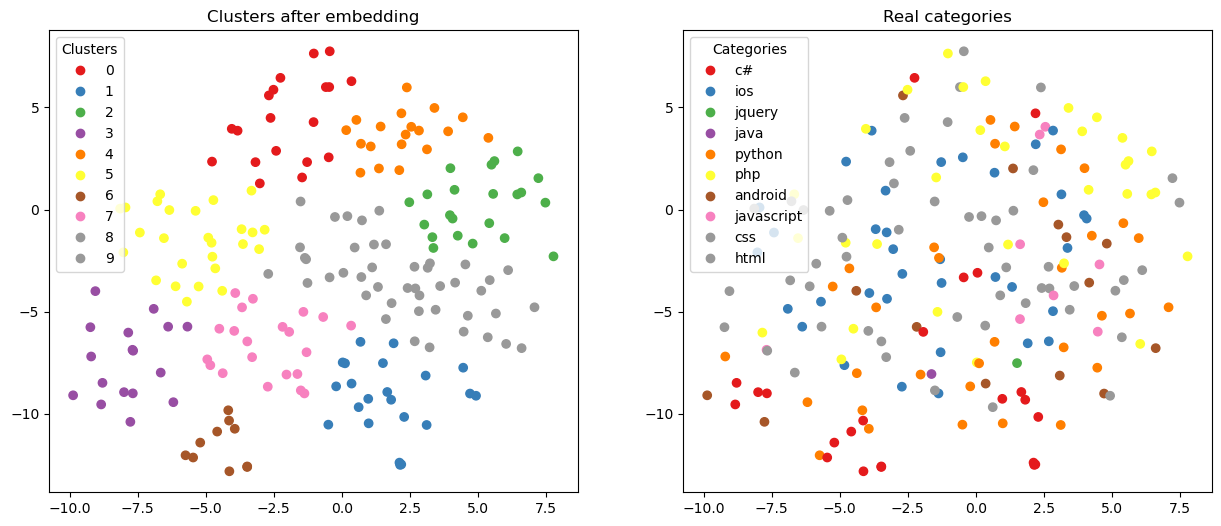

ARI :  0.0363


In [ ]:
TSNE_visu_fct(X_tsne_BERT, ARI_BERT, labels_BERT, df_test_BERT)

## Confusion Matrix

              precision    recall  f1-score   support

          c#       0.21      0.14      0.17        35
        java       0.29      0.19      0.23        32
  javascript       0.00      0.00      0.00        14
         ios       0.29      0.21      0.25        33
         php       0.11      0.09      0.10        22
     android       0.22      0.22      0.22        23
      python       0.40      0.39      0.39        31
      jquery       0.00      0.00      0.00         8
         css       0.00      0.00      0.00         1
        html       0.00      0.00      0.00         1

    accuracy                           0.18       200
   macro avg       0.15      0.12      0.13       200
weighted avg       0.23      0.18      0.20       200



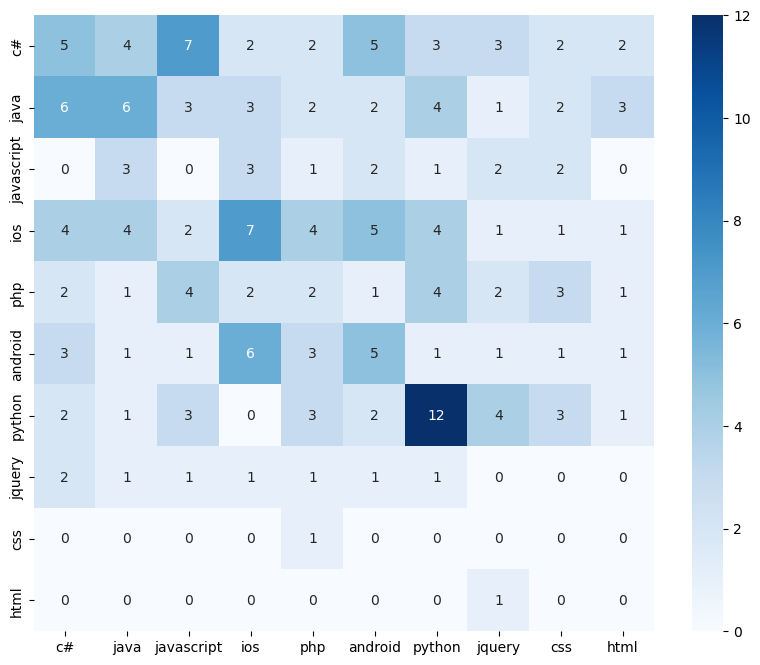

In [ ]:
Y_pred_BERT = lda_bert.predict(X_test_BERT)
report(Y_pred_BERT, df_test_BERT, df_BERT)

# USE

## Modelisation

In [ ]:
# Load model from TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


# USE embedding
def encode_text_with_use(texts, batch_size=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_embeddings = use_model(batch).numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)  

2025-03-22 16:23:42.076713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:

# USE embbedings
X_train_USE = encode_text_with_use(df_train["text"])
X_test_USE = encode_text_with_use(df_test["text"])


lda_USE = train_lda_model("LDA USE", X_train_USE, X_test_USE)


2025/03/22 16:29:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy : 0.87
Precision : 0.88, Recall : 0.87, F1 Score : 0.88
Model saved in MLflow.


## Embedding visualization

In [ ]:
ARI_USE, X_tsne_USE, labels_USE = ARI_fct(X_test_USE)

/home/omar-oc/anaconda3/envs/env_OC_P5_ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1894 time :  35.0


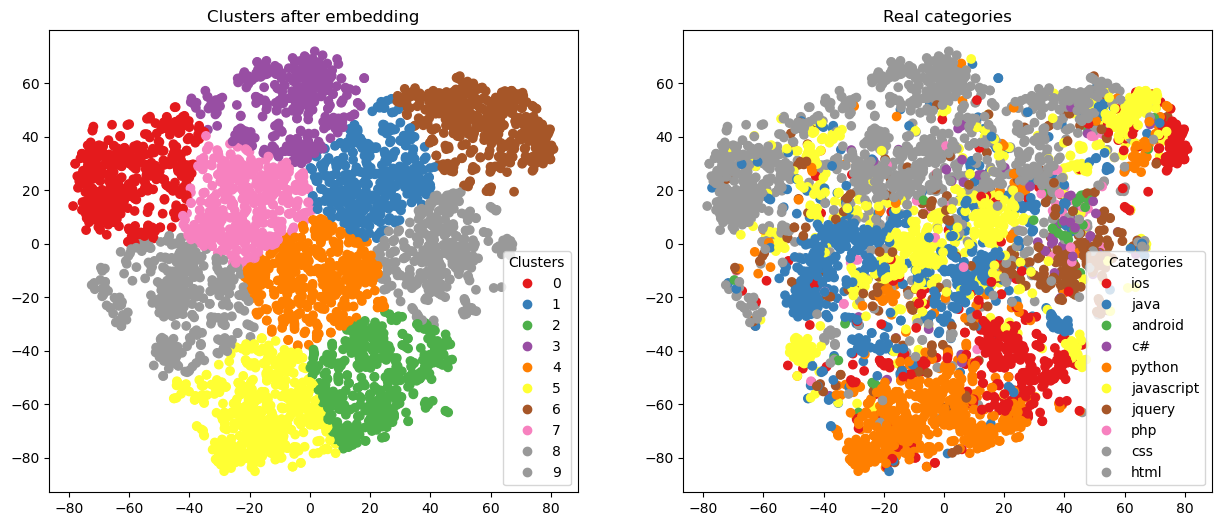

ARI :  0.1894


In [ ]:
TSNE_visu_fct(X_tsne_USE, ARI_USE, labels_USE)

## Confusion Matrix

              precision    recall  f1-score   support

  javascript       0.74      0.79      0.76       339
        java       0.89      0.90      0.90       762
        html       0.32      0.44      0.37        66
      python       0.92      0.93      0.92       871
      jquery       0.36      0.57      0.45        47
     android       0.89      0.86      0.88       471
         php       0.90      0.84      0.87       477
          c#       0.90      0.88      0.89       675
         ios       0.96      0.90      0.93       637
         css       0.66      0.70      0.68        53

    accuracy                           0.87      4398
   macro avg       0.76      0.78      0.77      4398
weighted avg       0.88      0.87      0.88      4398



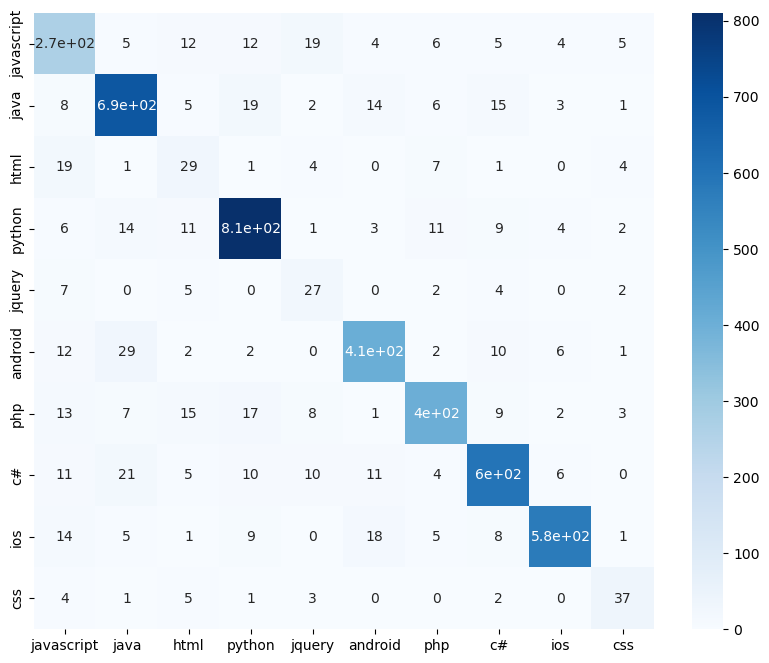

In [ ]:
Y_pred_USE = lda_USE.predict(X_test_USE)
report(Y_pred_USE)

# Saving

In [17]:
with open("lda_model.pkl", "wb") as f:
    pickle.dump(lda_tfidf, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

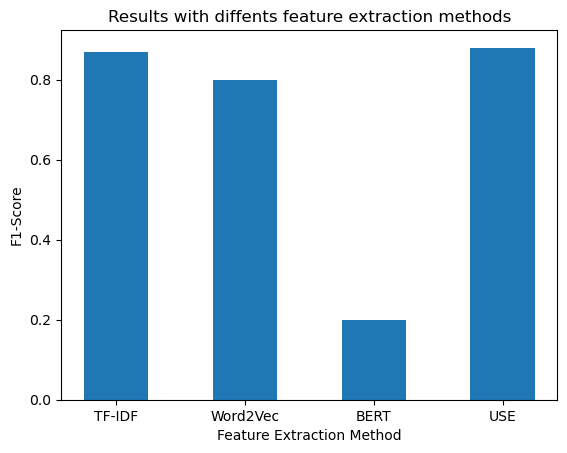

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Results with diffents feature extraction methods")
plt.xlabel("Feature Extraction Method")
plt.ylabel("F1-Score")
plt.bar(["TF-IDF", "Word2Vec", "BERT", "USE"], [0.87, 0.80, 0.20, 0.88], width = 0.5)
plt.show()